# Neural Style Transfer with Pretrained AlexNet
In this notebook, we explore the fascinating technique of neural style transfer using a pretrained AlexNet model. Neural style transfer allows us to combine the content of one image with the style of another image, resulting in visually appealing artworks that blend the content and style elements seamlessly.


## Introduction
Neural style transfer is a deep learning technique that uses convolutional neural networks (CNNs) to manipulate images in artistic ways. The process involves extracting feature maps from both a content image and a style image using a pretrained CNN, such as AlexNet. These feature maps capture the content and style information present in the respective images.

## Brief methodology:
**1. Data Preparation:** We begin by loading the content and style images that we want to combine. These images serve as the input for our neural style transfer algorithm.  
**2. Feature Extraction:** Next, we use the first five convolutional layers of the pretrained AlexNet model to extract feature maps from both the content and style images. These feature maps represent the content and style characteristics of the input images.  
**3. Gram Matrix Calculation:** We compute the Gram matrix for the style feature maps, which captures the style information in a compact form. The Gram matrix is essential for quantifying the style of an image.  
**4. Optimization:** we initialize a target image with the same content as the content image and use an optimization algorithm, such as Adam, to iteratively modify the target image. The goal is to minimize the difference between the feature maps of the target image and the content image, while also matching the Gram matrix of the target Feature maps with the Gram matrix of the style feature maps.  
**5. Result Visualization:** Finally, we visualize the resulting target image, which combines the content of the content image with the style of the style image. The target image exhibits a unique artistic style that is influenced by both the content and style images.

Lets look at the implementation shall we,

# Import the Libraries

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\Sekhar\AppData\Local\Temp\ipykernel_5140\671317168.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
# initialize GPU if available
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Import AlexNet and freeze all layers
as we are only trying to acces the convolutional layers of fully trained model. we can set the model to eval() mode.

In [3]:
# import the model
alexnet = torchvision.models.alexnet(pretrained=True)
# freeze all layers
for param in alexnet.parameters():
    param.requires_grad = False
# set to evaluation mode
alexnet.eval()
# send model to GPU
alexnet.to(device)

C:\Users\Sekhar\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sekhar\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Import two images

For this demonstration, I am using two beautiful images which are captured by myself.

In [4]:
contentImg = imread('policeGround.jpg')
styleImg   = imread('mosaic_glass_design.jpg')
print(contentImg.shape)
print(styleImg.shape)

C:\Users\Sekhar\AppData\Local\Temp\ipykernel_5140\1796144725.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  contentImg = imread('policeGround.jpg')
C:\Users\Sekhar\AppData\Local\Temp\ipykernel_5140\1796144725.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  styleImg   = imread('styleDivali.jpg')


(3000, 4000, 3)
(3000, 4000, 3)


Transforming the images before sending them through convolutional layers is very important.
since AlexNet is trained on one specific dataset so, to get best peroformance from model, we have to normalize the images the same way the images which are used to train the model.
also, it is good to resize the images to smaller resolutions to favor compute time.

In [5]:
# create the transforms and apply normalization to images (requied before feeding into model)
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) 
               ])
# apply them to the images ("unsqueeze" to make them a 4D tensor as model takes images in dD) and push to GPU
contentImg = Ts( contentImg ).unsqueeze(0).to(device)
styleImg   = Ts( styleImg   ).unsqueeze(0).to(device)
print(contentImg.shape)
print(styleImg.shape)

torch.Size([1, 3, 256, 341])
torch.Size([1, 3, 256, 341])


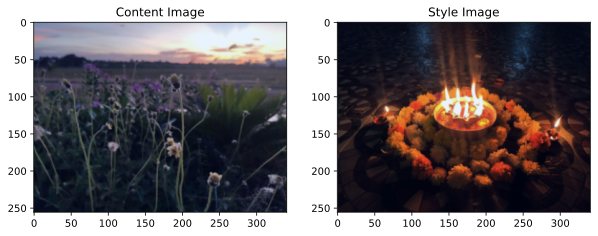

In [6]:
# Let's have a look at the input pictures
fig,ax = plt.subplots(1,2,figsize=(10,5))

pic = contentImg.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content Image')

pic = styleImg.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Style Image')

plt.show()

Is'nt the first image look good.

# Functions that extracts image feature map activations
These are the output result of convolution layer. once an image got convoluted by a convoluting kernel(here it is pretrained inside AlexNet) it becomes transformed into a beautiful feature map which picks up most of he spatial features of the image.

In [7]:
def getFeatureMaps(image, model):
    """
    Extracts feature maps from convolutional layers of a given model.

    Args:
    - image: Input image tensor.
    - model: Pretrained CNN model.

    Returns:
    - feature_maps: List of feature maps extracted from convolutional layers.
    - feature_names: List of names corresponding to each feature map.
    """
    # Initialize lists to store feature maps and their corresponding names
    feature_maps = []
    feature_names = []
    
    # Counter for convolutional layers
    conv_layer_idx = 0
    
    # Iterate through all layers in the "features" block of the model
    for layer_num, layer in enumerate(model.features):
        # Process the image through each layer
        image = layer(image)
        
        # Check if the layer is a Conv2d layer
        if isinstance(layer, nn.Conv2d):
            # Append the feature map and its name to the lists
            feature_maps.append(image)
            feature_names.append(f'ConvLayer_{conv_layer_idx}')
            conv_layer_idx += 1
    
    return feature_maps, feature_names


In [8]:
def gram_matrix(feature_map):
    """
    Computes the Gram matrix of a given feature activation map.

    Args:
    - feature_map: Feature activation map tensor.

    Returns:
    - gram_matrix: Gram matrix computed from the feature activation map.
    """
    # Reshape the feature map to 2D
    batch_size, channels, height, width = feature_map.shape
    feature_map = feature_map.view(channels, height * width)
    
    # Compute the covariance matrix (Gram matrix)
    gram_matrix = torch.mm(feature_map, feature_map.t()) / (channels * height * width)
    
    return gram_matrix


In [9]:
# inspect the data coming out of Convolution layers
featmaps,featnames = getFeatureMaps(contentImg,alexnet)

# print out shape of the images
for i in range(len(featnames)):
  print('Size of Feature map of "%s" is %s'%(featnames[i],(featmaps[i].shape)))

Size of Feature map of "ConvLayer_0" is torch.Size([1, 64, 63, 84])
Size of Feature map of "ConvLayer_1" is torch.Size([1, 192, 31, 41])
Size of Feature map of "ConvLayer_2" is torch.Size([1, 384, 15, 20])
Size of Feature map of "ConvLayer_3" is torch.Size([1, 256, 15, 20])
Size of Feature map of "ConvLayer_4" is torch.Size([1, 256, 15, 20])


([1, 64, 63, 84]) is a 4D matrix:  
1st dimension (1) -  represents no of images send into the model.  
2ns dimension (64) -  represents no of channels in that feature map. in other words, there is a 64 channel image formed for one input image of 3 channel(RGB)  
3rd dimension (63) -  represents width of the image.  
4th dimension (84) -  represents height of the image.  

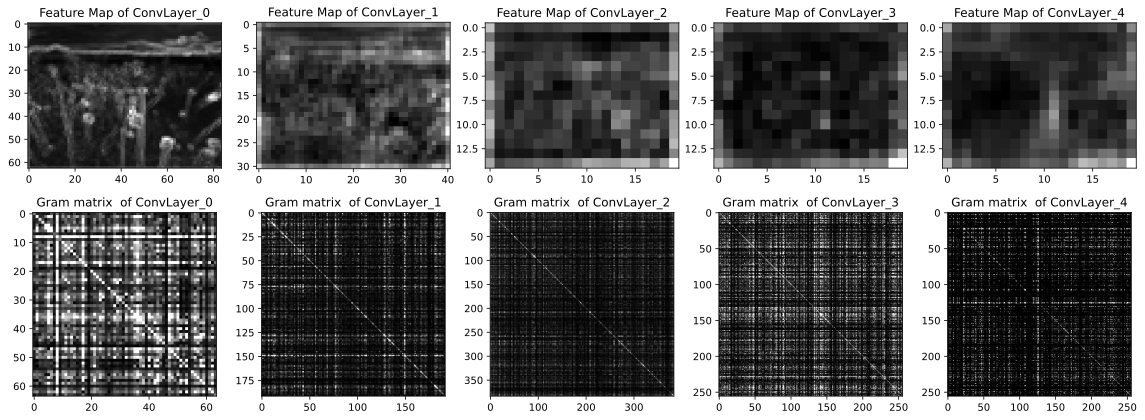

In [10]:
def plotFeatureMaps(feature_maps, feature_names):
    """
    Plot the feature maps and their corresponding Gram matrices.

    Args:
    - feature_maps: List of feature map tensors.
    - feature_names: List of names corresponding to the feature maps.
    """
    fig, axs = plt.subplots(2, 5, figsize=(16, 6))
    
    for i in range(5):
        # Compute the average of feature maps and normalize
        avg_map = np.mean(feature_maps[i].cpu().squeeze().numpy(), axis=0)
        avg_map = (avg_map - np.min(avg_map)) / (np.max(avg_map) - np.min(avg_map))
        
        axs[0, i].imshow(avg_map, cmap='gray')
        axs[0, i].set_title('Feature Map of ' + str(feature_names[i]))

        # Compute and show the Gram matrix
        gram_map = gram_matrix(feature_maps[i]).cpu().numpy()
        gram_map = (gram_map - np.min(gram_map)) / (np.max(gram_map) - np.min(gram_map))

        axs[1, i].imshow(gram_map, cmap='gray', vmax=0.1)
        axs[1, i].set_title('Gram matrix  of ' + str(feature_names[i]))

    plt.tight_layout()
    plt.show()

contentFeatureMaps,contentFeatureNames = getFeatureMaps(contentImg,alexnet)
plotFeatureMaps(contentFeatureMaps,contentFeatureNames)

As you can see form the top row, the feature map from 1st comvolution layer is more detailed as it has highest resolution among all. and it is able to caputure the structural details of te content image. and below is the corelation matrix or gram matrix of the above feature maps. for the sake of this project we are not going to use gram matrix of content feature map.

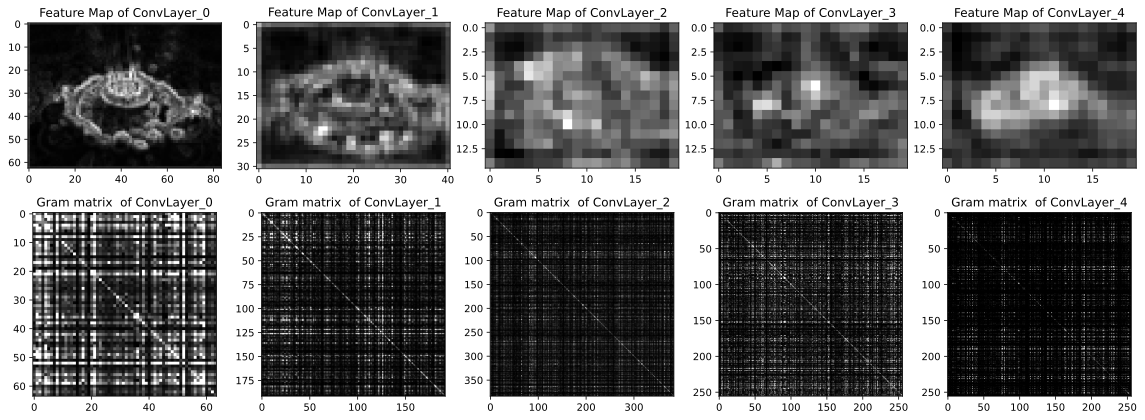

In [11]:
# lets look at the feature maps and gram matrix of style image
styleFeatureMaps,styleFeatureNames = getFeatureMaps(styleImg,alexnet)
plotFeatureMaps(styleFeatureMaps,styleFeatureNames)

Here the 1st feature map has detected most of the image outline from the style image. but we dont need those big image patterns. what we need is the spatial representations of the individual pixel. for that we compute gram matrix whic we can see in the below row. we try to match this gram matrix with the traget image feature map gram matrix. so recreate similar spatial patterns on the target image.

# Now its time to train our target image: 
to look like both Content image as well as show spatial patterns as in Style image

In [12]:
# Choose the feature maps
chosen_content_FM = ['ConvLayer_0']  # Going with only 1st conv layer as it provides perfect image structure.
chosen_style_FM = ['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4']
weights_for_chosen_style_FM = [1, 0.95, 0.75, 0.55, 0.35]  # More weightage to early feature maps as they carry more detailed patterns.

# Initialize the target image as the content image
target = contentImg.clone()   #def img4content
target.requires_grad = True
target = target.to(device)
style_scaling = 1e4   

# Number of epochs to train
num_epochs = 1500

# Optimizer for backprop
optimizer = torch.optim.RMSprop([target], lr=0.001)

for epoch in range(num_epochs):

    # Extract the target feature maps
    target_feature_maps, target_feature_names = getFeatureMaps(target, alexnet)

    # Initialize the individual loss components
    style_loss = 0
    content_loss = 0

    # Loop over layers
    for layer_idx in range(len(target_feature_names)):

        # Compute the content loss
        if target_feature_names[layer_idx] in chosen_content_FM:
            content_loss += torch.mean((target_feature_maps[layer_idx] - contentFeatureMaps[layer_idx]) ** 2)

        # Compute the style loss
        if target_feature_names[layer_idx] in chosen_style_FM:
            # Gram matrices
            G_target = gram_matrix(target_feature_maps[layer_idx])
            G_style = gram_matrix(styleFeatureMaps[layer_idx])

            # Compute their loss
            style_loss += torch.mean((G_target - G_style) ** 2) * weights_for_chosen_style_FM[chosen_style_FM.index(target_feature_names[layer_idx])]

    # Combined loss of content and style
    combined_loss = style_scaling * style_loss + content_loss

    # Backpropagation
    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()


# Let's have a look at our result

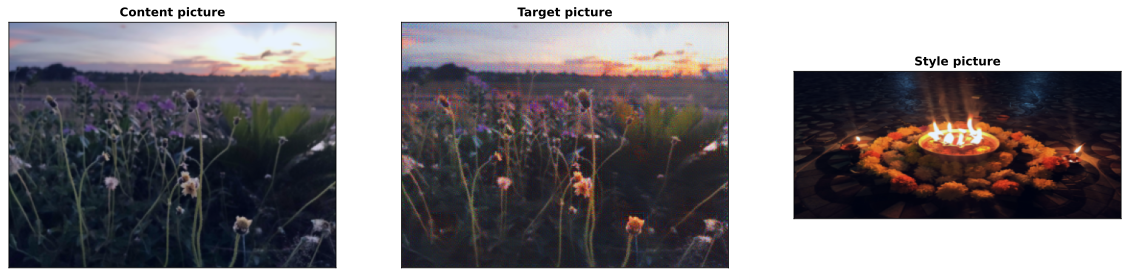

In [13]:
# Lets look at the generated stylised picture
fig,ax = plt.subplots(1,3,figsize=(20,10))

pic = contentImg.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = styleImg.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

## Conclusion: 
As you can see in the Target Picture, the image has turn into slightly artistic by the influence of the patterns from the style picture. the flowers at the middle have become much brighter just like divali diyas as in style picture.
Gram matric has the capabilitis to caputre spatial corelations, hence it is able to capture such style pattern from style image and recreate that pattern in target image.  

Neural style transfer offers a powerful tool for creating artistic images with rich visual textures. By leveraging pretrained CNN models like AlexNet, we can manipulate images in creative ways, producing captivating artworks that blend the content and style elements from different sources. This notebook serves as a hands-on exploration of neural style transfer techniques, demonstrating the potential for using deep learning to generate visually stunning imagery.